In [9]:
import os, sys, time, resource, re, gc, shutil
import operator
from multiprocess import Pool
from functools import partial
from urllib.parse import urlparse, parse_qsl
from django.db.models import Count
import matplotlib


mp_pdf = False
if mp_pdf:
    extension = "pdf"
    import matplotlib
    matplotlib.use('pgf')
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "xelatex",
        "figure.figsize": [12,7]
    }
    matplotlib.rcParams.update(pgf_with_latex)
else:
    extension = "png"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django
from adjustText import adjust_text

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *

from run_id import run_id

run_id = 1861

runstat = RunStats.objects.get(pk=run_id)
topics = DynamicTopic.objects.filter(run_id=run_id)

docs = Doc.objects.filter(
    query=runstat.query,
    content__iregex="\w"
)



In [10]:
years = list(range(1990,2015))
years

s_solutions = []
ip_solutions = []

r = "(?:\W|^)policy"

for y in years:
    ydocs = docs.filter(PY=y)
    sdocs = ydocs.filter(content__iregex=r)
    s_count = sdocs.count()
    s_solutions.append(s_count/ydocs.count())
    ip_docs = ydocs.filter(ipccref__isnull=False)
    ip_solution_docs = ip_docs.filter(content__iregex=r)
    try:
        ip_solutions.append(ip_solution_docs.count()/ip_docs.count())
    except:
        ip_solutions.append(0)
    #ipdocs = ydocs.filter()
    

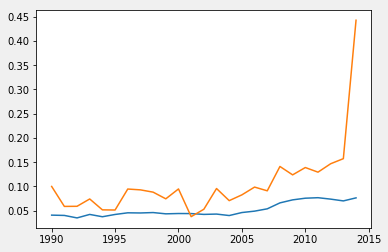

In [11]:
fig = plt.figure()

plt.plot(years,s_solutions)
plt.plot(years, ip_solutions)

fig.patch.set_facecolor('#f0f0f0')    
#plt.tight_layout()

plt.savefig(
    f'../plots/solutions.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
)
plt.show()

In [12]:
if runstat.method=="DT":
    dts = DocTopic.objects.filter(
        run_id=run_id,
        doc__PY__lt=2014,
        score__gt=runstat.dt_threshold,
        topic__topicdtopic__dynamictopic__run_id=run_id,
        topic__topicdtopic__score__gt=runstat.dt_threshold
    ).values('topic__topicdtopic__dynamictopic__id')

    dts = dts.annotate(
        solution = models.Sum(
            models.Case(
                models.When(
                    doc__content__iregex=r,
                    then=F('score')*F('topic__topicdtopic__score')
                ),
                default=0,
                output_field=models.FloatField()
            )
        )
    )

    df = pd.DataFrame.from_dict(list(dts.values(
        'topic__topicdtopic__dynamictopic__title',
        'solution',
        'topic__topicdtopic__dynamictopic__score'
    ))).rename(columns={
        'topic__topicdtopic__dynamictopic__title':'topic__title',
        'topic__topicdtopic__dynamictopic__score': 'score'
    })
else:
    dts = DocTopic.objects.filter(
        run_id=run_id,
        doc__PY__lt=2014,
        score__gt=runstat.dt_threshold,
    ).values('topic__title')

    dts = dts.annotate(
        solution = models.Sum(
            models.Case(
                models.When(
                    doc__content__iregex=r,
                    then=F('score')
                ),
                default=0,
                output_field=models.FloatField()
            )
        )
    )

    df = pd.DataFrame.from_dict(list(dts.values(
        'topic__title',
        'solution',
        'score'
    )))
    
df.head()
                                     
                                    


,score,solution,topic__title
0,0.0005,0.0000,"{absorption, solvent, amine}"
1,0.0005,0.0005,"{absorption, solvent, amine}"
2,0.0005,0.0000,"{absorption, solvent, amine}"
3,0.0005,0.0000,"{absorption, solvent, amine}"
4,0.0005,0.0000,"{absorption, solvent, amine}"


In [13]:
topics = Topic.objects.filter(
    run_id=run_id,
    #primary_wg=3
).values('doctopic__doc__wc__oecd').annotate(
    dis_share = Sum('doctopic__score')
)

topic_dis_df = pd.DataFrame.from_dict(list(topics.values(
    'title','doctopic__doc__wc__oecd','dis_share','primary_wg'
)))

print(topic_dis_df.shape)

topic_dis_df.head()

(980, 4)


,dis_share,doctopic__doc__wc__oecd,primary_wg,title
0,10.952318,Agricultural Sciences,1,"{absorption, solvent, amine}"
1,27.374187,Agricultural Sciences,2,"{adaptation, vulnerability, strategy}"
2,10.807839,Agricultural Sciences,2,"{adsorption, capacity, adsorbent}"
3,5.370976,Agricultural Sciences,1,"{aerosol, forcing, radiative}"
4,27.950151,Agricultural Sciences,1,"{air, pollution, quality}"


In [ ]:
topics = Topic.objects.filter(
    run_id=run_id,
    #primary_wg=3
).filter(
    doctopic__doc__PY__lt=2014
).values('doctopic__doc__wc__oecd').annotate(
    dis_share_pre = Sum('doctopic__score')
)

topic_dis_df_pre = pd.DataFrame.from_dict(list(topics.values(
    'title','doctopic__doc__wc__oecd','dis_share_pre','primary_wg'
)))

topics = Topic.objects.filter(
    run_id=run_id,
    #primary_wg=3
).filter(
    doctopic__doc__PY__gte=2014
).values('doctopic__doc__wc__oecd').annotate(
    dis_share_post = Sum('doctopic__score')
)

topic_dis_df_post = pd.DataFrame.from_dict(list(topics.values(
    'title','doctopic__doc__wc__oecd','dis_share_post','primary_wg'
)))



In [19]:
new_df = pd.merge(topic_dis_df, topic_dis_df_pre, topic_dis_df_post)
new_df.head()

,dis_share,doctopic__doc__wc__oecd,primary_wg,title,dis_share_pre
0,10.952318,Agricultural Sciences,1,"{absorption, solvent, amine}",5.651488
1,27.374187,Agricultural Sciences,2,"{adaptation, vulnerability, strategy}",10.406468
2,10.807839,Agricultural Sciences,2,"{adsorption, capacity, adsorbent}",5.456740
3,5.370976,Agricultural Sciences,1,"{aerosol, forcing, radiative}",3.119727
4,27.950151,Agricultural Sciences,1,"{air, pollution, quality}",17.567241


In [14]:
topic_dis_wide = topic_dis_df.pivot_table(
    index=["title","primary_wg"],columns="doctopic__doc__wc__oecd",values="dis_share"
).reset_index()
topic_dis_wide.head()

doctopic__doc__wc__oecd,title,primary_wg,Agricultural Sciences,Engineering and Technology,Humanities,Medical and Health Sciences,Natural Sciences,Social Sciences
0,"{absorption, solvent, amine}",1,10.952318,157.734286,0.655637,1.408695,121.261018,8.638261
1,"{adaptation, vulnerability, strategy}",2,27.374187,35.427637,2.070644,5.084364,168.914768,70.146774
2,"{adsorption, capacity, adsorbent}",2,10.807839,103.211870,0.541969,1.267626,145.276875,8.423910
3,"{aerosol, forcing, radiative}",1,5.370976,41.531185,0.427639,0.851780,206.180061,3.741547
4,"{air, pollution, quality}",1,27.950151,113.550310,1.341901,7.667993,210.746362,22.470921


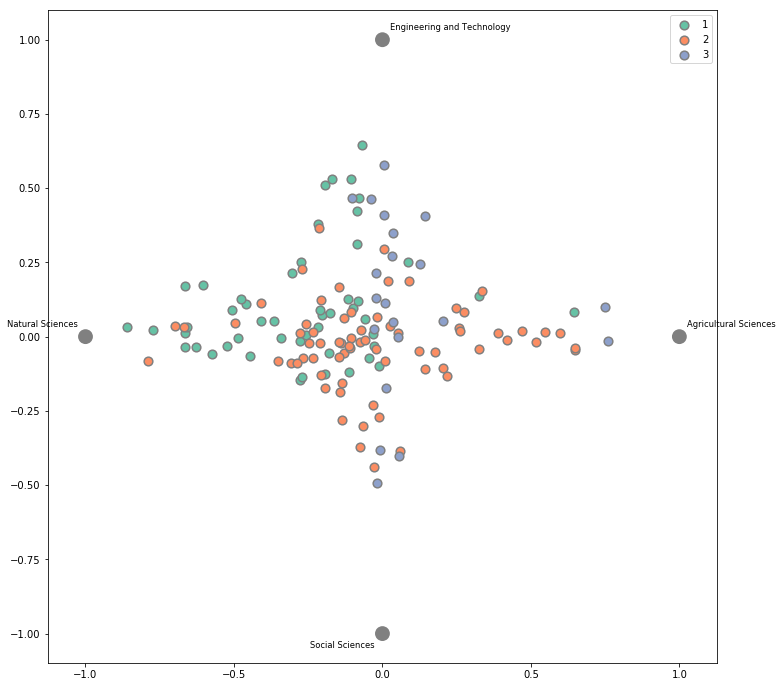

In [15]:

fig, ax = plt.subplots(figsize=(12,12))

cols = [
    "primary_wg",
    "Agricultural Sciences", 
    "Engineering and Technology",
    "Natural Sciences", 
    "Social Sciences"
]

rad_viz = pd.plotting.radviz(
    topic_dis_wide[cols].sort_values('primary_wg'), 
    'primary_wg', 
    ax=ax,
    color=["#66c2a5","#fc8d62","#8da0cb"],
    edgecolors="grey",
    linewidths=1.5,
    s = 75
) 

plt.show()

In [16]:
topic_dis_df.to_csv(f'../tables/topic_discipline_{run_id}.csv',index=False)